In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xarray as xr
import pandas as pd

import itertools
import datetime
import time
import sys  
import re

sys.path.insert(0, '../')

from soundings.deep_learning import mlutilities as ml
from soundings.deep_learning import tf_neuralnetwork as nn
from soundings.deep_learning import tf_metrics as metrics

from soundings.preprocessing import dataloader

from soundings.plotting import radiosonde_plotting, results
from soundings.utils import radiosonde_products, radiosonde_utils

from IPython.display import display
from ipywidgets import FloatProgress

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
processed_vol = '/mnt/data1/stock/mlsoundings/processed/'
PLOT_CMAP = 'RdYlBu_r'

gpus = tf.config.get_visible_devices('GPU')
for device in gpus:
    print(device)
    # tf.config.experimental.set_visible_devices(device, 'GPU')
    tf.config.experimental.set_memory_growth(device, True)
print()
!nvidia-smi

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

Mon Sep 21 15:49:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:3D:00.0 Off |                  Off |
| 33%   30C    P8    12W / 260W |     16MiB / 24212MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----

# Evaluation Functions

In [3]:
def parition(rap=None, raob=None, goes=None, rtma=None, 
             percentages=(0.8,0.2), shuffle=False):
    
    trainFraction, testFraction = percentages
    n = raob.shape[0]
    nTrain = round(trainFraction * n)
    nTest = round(testFraction * n)
    rowIndices = np.arange(n)
    if shuffle:
        np.random.shuffle(rowIndices)
        
    RAPtrain  = None
    RAPtest   = None
    RAOBtrain = None
    RAOBtest  = None
    GOEStrain = None
    GOEStest  = None
    RTMAtrain = None
    RTMAtest  = None
    
    if rap is not None:
        RAPtrain = rap[rowIndices[:nTrain], :]
        RAPtest  = rap[rowIndices[nTrain:nTrain+nTest], :]
        
    if raob is not None:
        RAOBtrain = raob[rowIndices[:nTrain], :]
        RAOBtest  = raob[rowIndices[nTrain:nTrain+nTest], :]
        
    if goes is not None:
        GOEStrain = goes[rowIndices[:nTrain], :]
        GOEStest  = goes[rowIndices[nTrain:nTrain+nTest], :]
        
    if rtma is not None:
        RTMAtrain = rtma[rowIndices[:nTrain], :]
        RTMAtest  = rtma[rowIndices[nTrain:nTrain+nTest], :]
    
    return (RAPtrain, RAOBtrain, GOEStrain, RTMAtrain,
            RAPtest, RAOBtest, GOEStest, RTMAtest)

# Data Loader

In [16]:
raob, rap, goes, rtma, sonde_files = dataloader.load_preprocessed_samples(processed_vol, shuffle=True)

print(raob.shape, rap.shape, goes.shape, rtma.shape)

total of 735 samples!


FloatProgress(value=0.0, max=735.0)

time: 18.633, avg: 0.025 seconds
(735, 256, 4) (735, 256, 4) (735, 3, 3, 8) (735, 3, 3, 3)


In [5]:
ml.rmse(rap[:,:,DEWPOINT], raob[:,:,DEWPOINT]), ml.rmse(rap[:,:,TEMPERATURE], raob[:,:,TEMPERATURE])

(4.810772620409847, 1.3815068064243756)

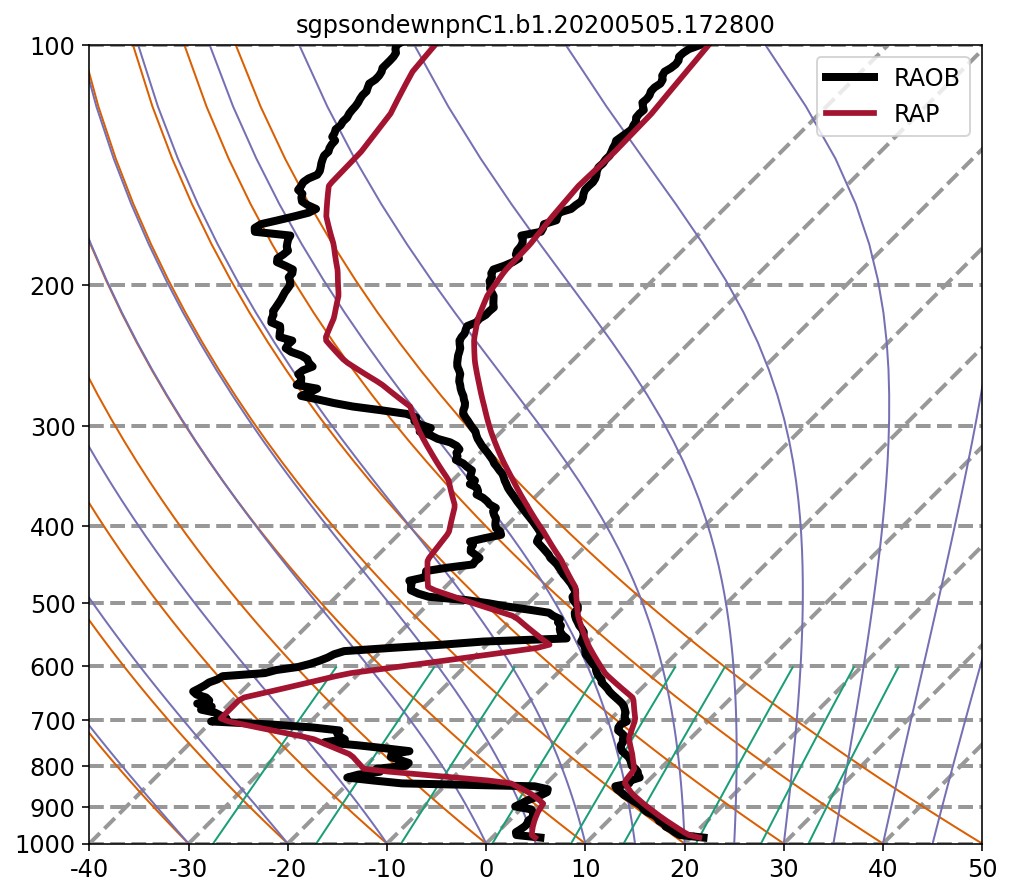

In [9]:
index = 1
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = rap[index,:,PRESSURE]

sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = raob[index,:,TEMPERATURE]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = rap[index,:,TEMPERATURE]

sounding[radiosonde_utils.DEWPOINT_COLUMN_KEY] = raob[index,:,DEWPOINT]
sounding[radiosonde_utils.NWP_DEWPOINT_COLUMN_KEY] = rap[index,:,DEWPOINT]

title = sonde_files[index].split('/')[-1][:-4]
radiosonde_plotting.plot_nwp_ml_sounding(sounding, title_string=title);
                                         # file_name=f"/home/stock/research/media/{title}-rapvraob.png");

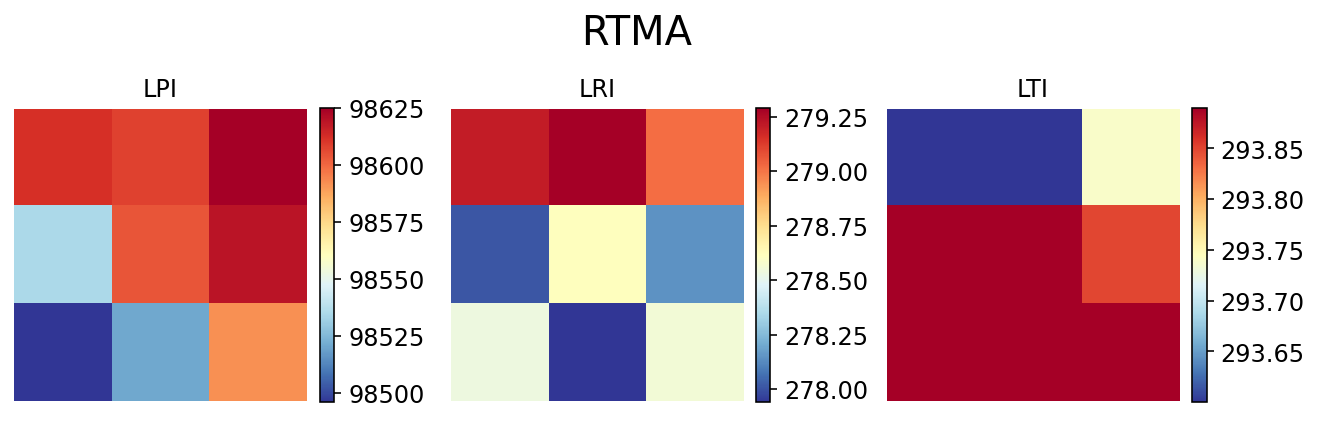

In [10]:
rtma_type = np.array(['LPI', 'LRI', 'LTI'])

fig, axs = plt.subplots(1, 3, figsize=(9,3))
[axi.set_axis_off() for axi in axs.ravel()]
for i in range(3):
    c = axs[i].imshow(rtma[index,:,:,i], cmap=PLOT_CMAP)
    fig.colorbar(c, ax=axs[i], fraction=0.046, pad=0.04)
    axs[i].set_title(f'{str(rtma_type[i])}')
fig.suptitle('RTMA', fontsize=20)
fig.tight_layout()

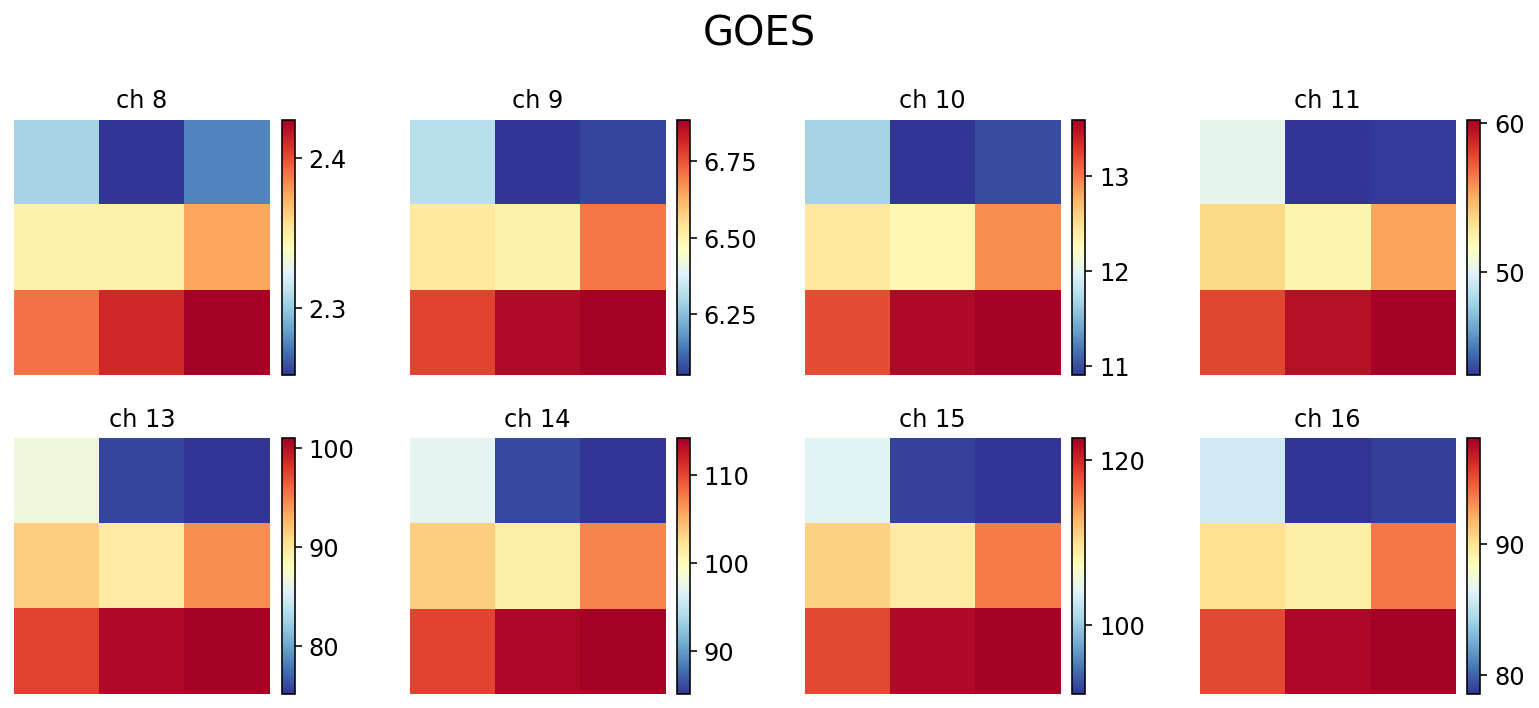

In [11]:
bands = np.array([8, 9, 10, 11, 13, 14, 15, 16])

# vmin = goes[index,:,:,:].min()
# vmax = goes[index,:,:,:].max()

fig, axs = plt.subplots(2, 4, figsize=(11,5))
[axi.set_axis_off() for axi in axs.ravel()]
r = 0
for i in range(8):
    if i >= 4: r = 1
    c = axs[r, i % 4].imshow(goes[index,:,:,i], cmap=PLOT_CMAP) # vmin=vmin, vmax=vmax,
    cbar = fig.colorbar(c, ax=axs[r, i % 4], fraction=0.046, pad=0.04)
    cbar.ax.locator_params(nbins=3)
    axs[r, i % 4].set_title(f'ch {str(bands[i])}')
plt.suptitle('GOES', fontsize=20)
fig.tight_layout()

# RAP + RTMA

### Temperature

In [256]:
RAPtrain, RAOBtrain, _, RTMAtrain, RAPtest, RAOBtest, _, RTMAtest = parition(rap=rap, raob=raob, rtma=rtma)

input_dims = [PRESSURE, TEMPERATURE]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, TEMPERATURE]

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, TEMPERATURE]

RAPtrain.shape, RAOBtrain.shape, RTMAtrain.shape, RAPtest.shape, RAOBtest.shape, RTMAtest.shape

((587, 256, 2),
 (587, 256),
 (587, 3, 3, 3),
 (147, 256, 2),
 (147, 256),
 (147, 3, 3, 3))

In [257]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

goes_hiddens_list = [[nu] * nl for nu in [8, 16, 32] for nl in range(1, 4)]
n_units_in_conv_layers = [[nu] * nl for nu in [16, 32, 128] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(goes_hiddens_list, n_units_in_conv_layers))

f = FloatProgress(min=0, max=len(product))
display(f)

for goes_hiddens, n_units_in_conv in product:
    nnet = nn.MultiNeuralNetwork(RTMAtrain.shape[1:], RAPtrain.shape[1:],
                                    goes_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                                    RAOBtrain.shape[1], im_activation='tanh', rap_activation='tanh', seed=1234)
    nnet.train(RTMAtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
               verbose=False, learning_rate=0.001)

    Y = nnet.use({'im': RTMAtrain, 'rap': RAPtrain})
    train_percentage.append(ml.rmse(RAOBtrain, Y))

    Y = nnet.use({'im': RTMAtest, 'rap': RAPtest})
    temp = ml.rmse(RAOBtest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=81.0)

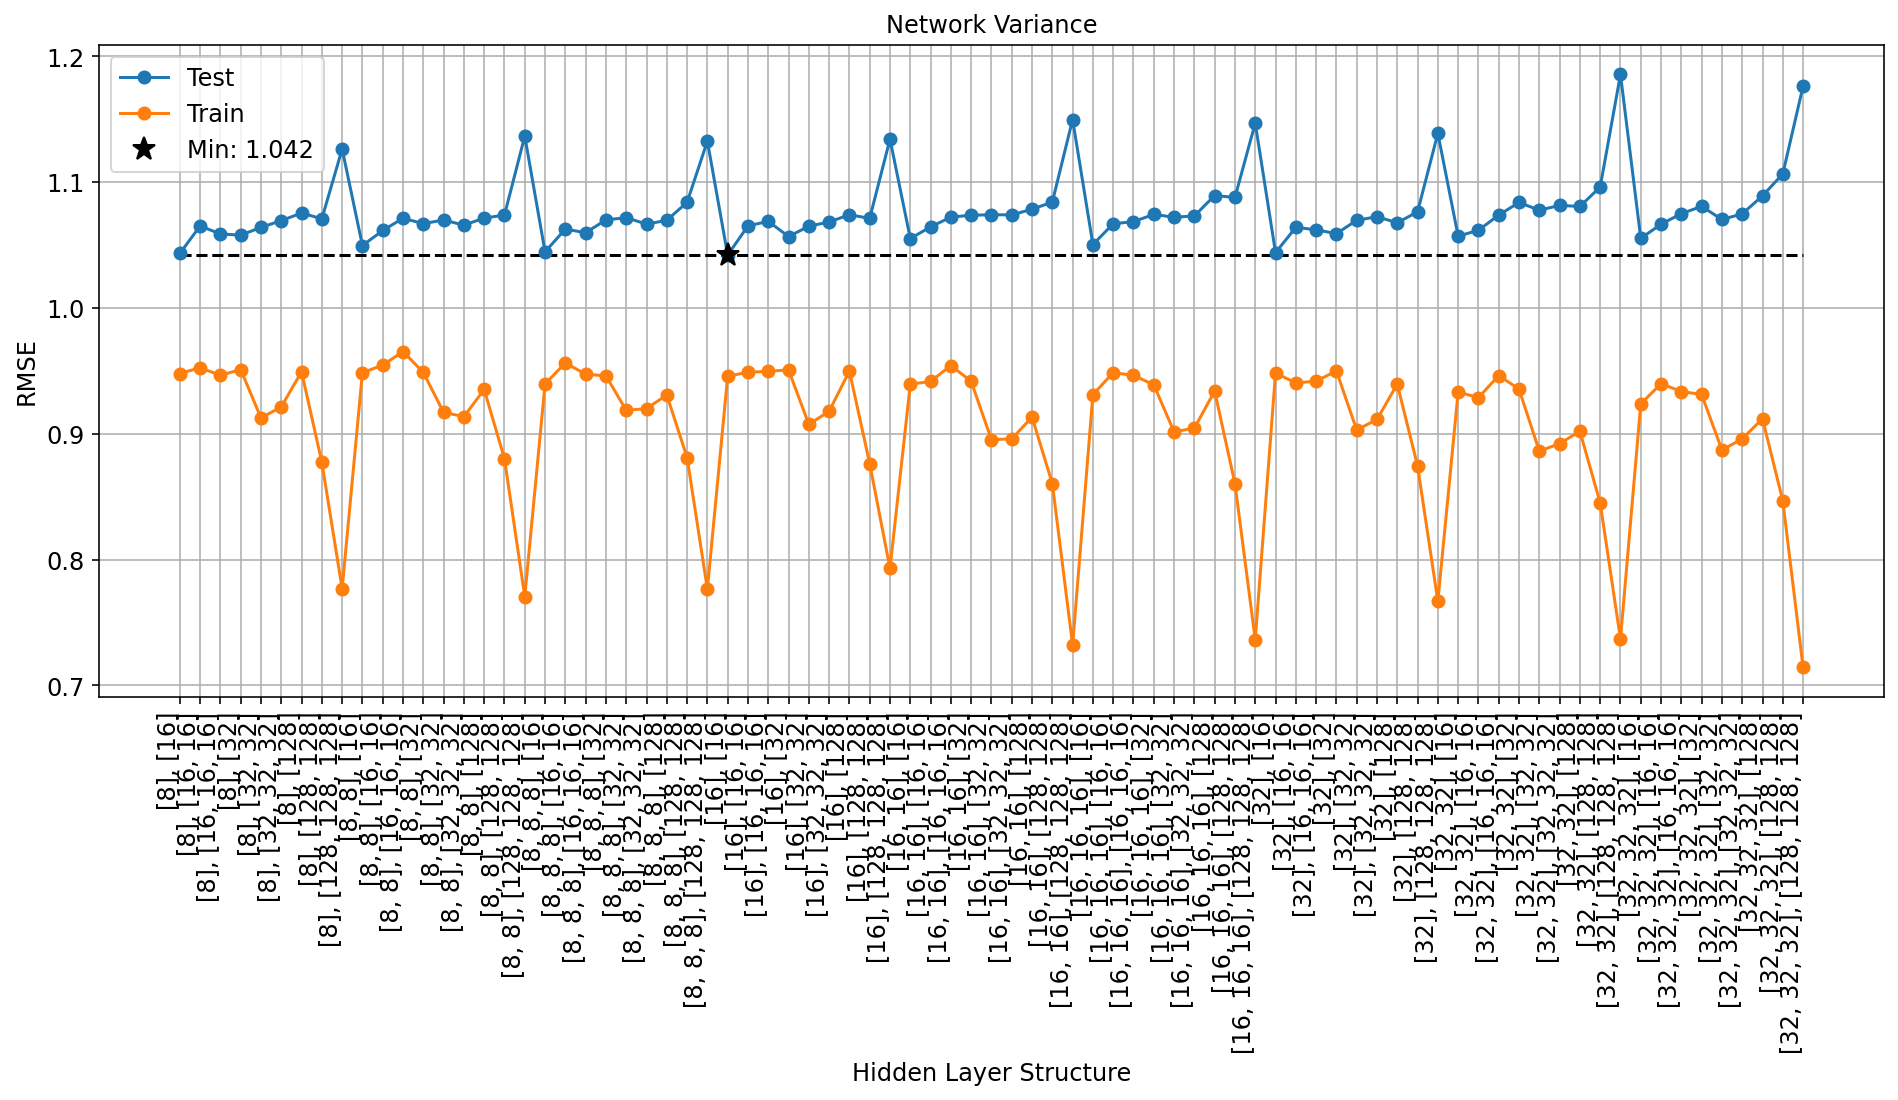

In [258]:
plt.figure(figsize=(16, 6))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

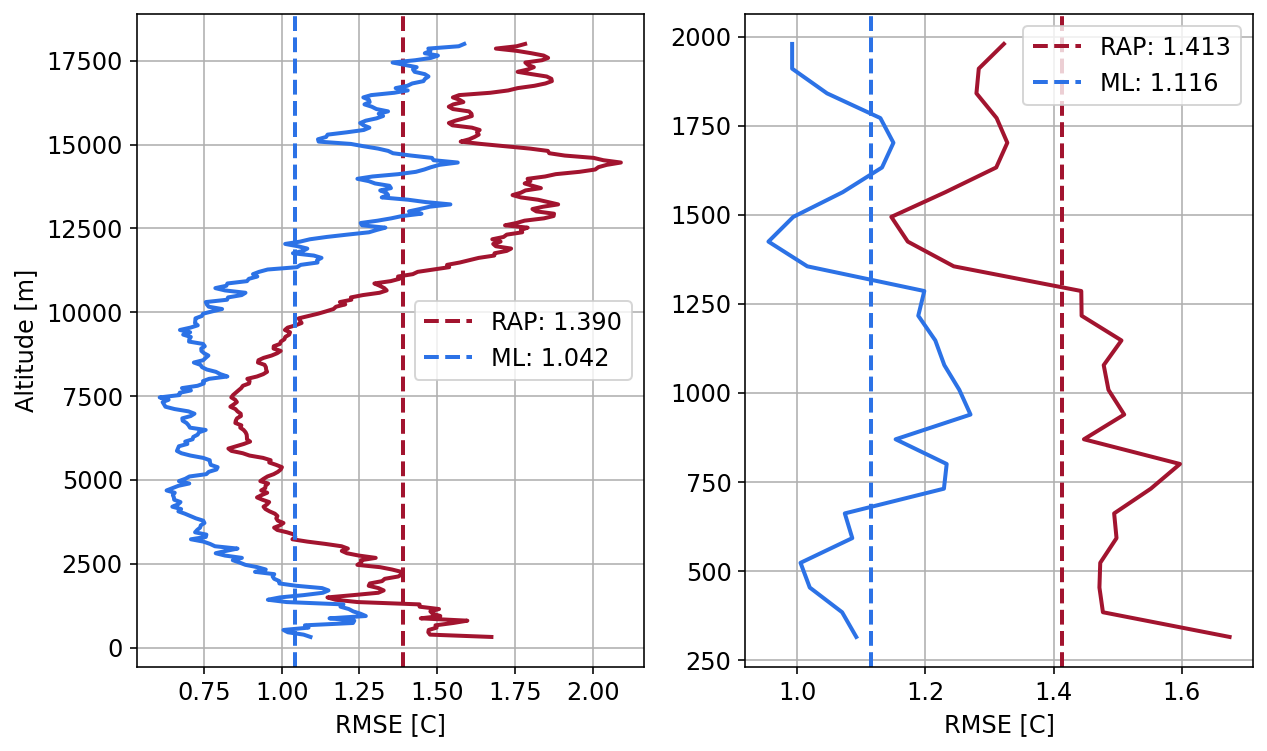

In [259]:
plot_altitude_rmse_verticle(best_nnet, {'im': RTMAtest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

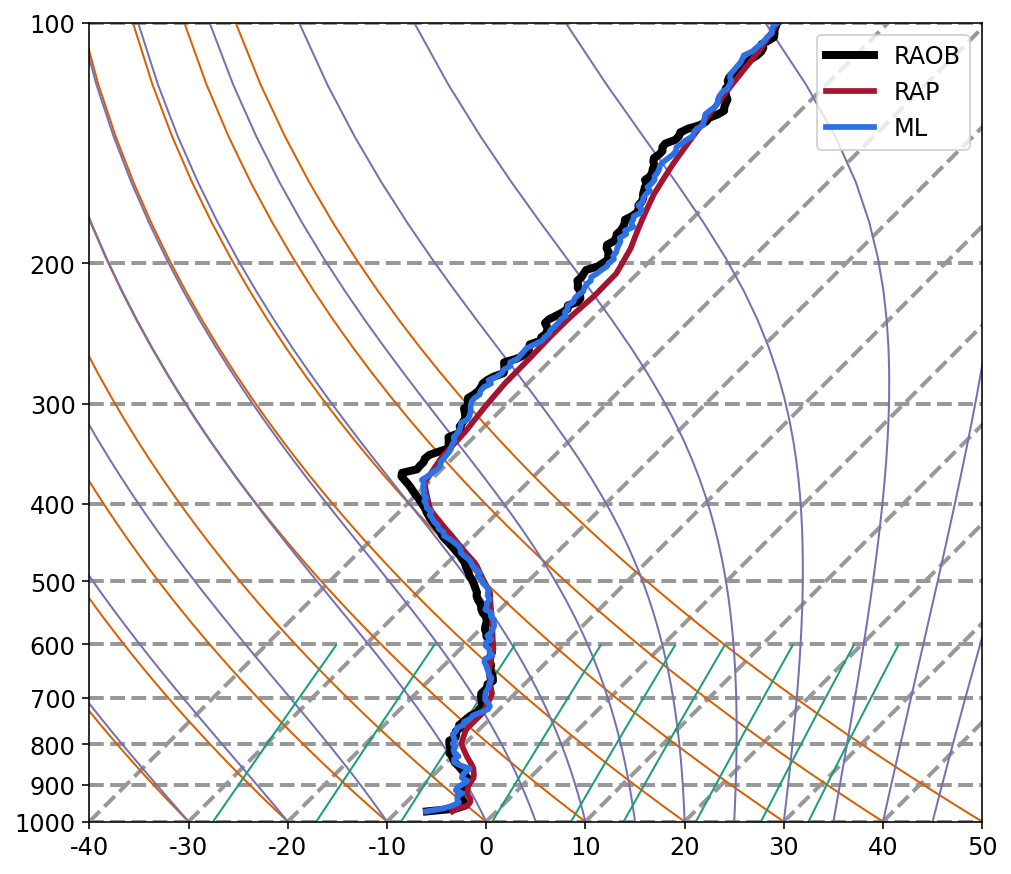

In [260]:
i = 17
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use({'im':RTMAtrain[i:i+1],'rap':RAPtrain[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

In [261]:
interm = tf.keras.Model(best_nnet.model.inputs,best_nnet.model.get_layer('concatenate').output)
def iterm_predict(goes, rap):
    goes = best_nnet._standardizeIM(goes)
    rap  = best_nnet._standardizeRAP(rap)
    return interm.predict({'im': goes, 'rap': rap})

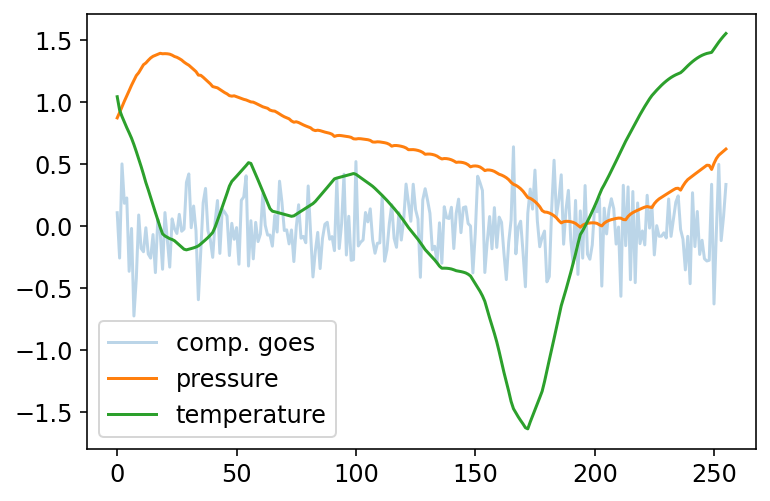

In [262]:
i = 2
Y = iterm_predict(RTMAtrain[i:i+1], RAPtrain[i:i+1])

plt.plot(Y[0,:,2], alpha=0.3, label='comp. goes')
plt.plot(Y[0,:,0], label='pressure')
plt.plot(Y[0,:,1], label='temperature')

plt.legend();

In [231]:
rtma_type_indicies = np.arange(len(rtma_type))
combinations = []
for length in rtma_type_indicies:
    combinations += list(itertools.combinations(rtma_type_indicies, length+1))

In [200]:
all_trials = []

for c in combinations:

    IMtrain = RTMAtrain[:,:,:, c]
    IMtest = RTMAtest[:,:,:, c]

    trial = []

    for t in range(10):
        nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                                    [16], [16], [(10, 1)], 
                                    RAOBtrain.shape[1], im_activation='tanh',
                                    rap_activation='tanh')

        nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
                   verbose=False, learning_rate=0.001)

        Y = nnet.use({'im': IMtest, 'rap': RAPtest})
        rmse = ml.rmse(Y, RAOBtest)

        trial.append(rmse)
        
    all_trials.append(trial)
    
all_trials = np.asarray(all_trials)

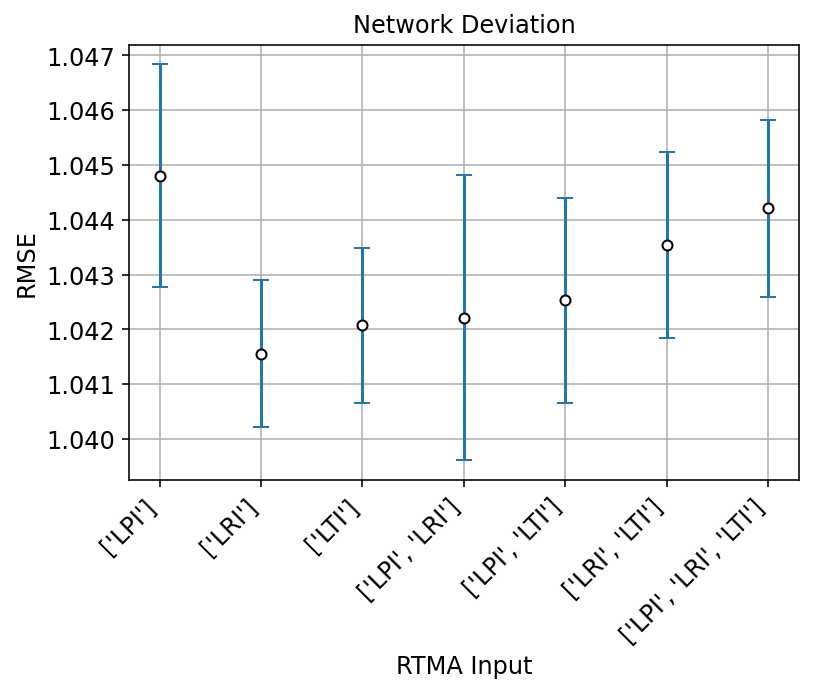

In [201]:
labels = [rtma_type[list(c)].tolist() for c in combinations]

fig, ax = plt.subplots(1, figsize=(6, 4))

ax.errorbar(np.arange(len(combinations)), all_trials.mean(axis=1), yerr=all_trials.std(axis=1),
             linestyle='None', marker='o', capsize=4, markersize=5,
             markeredgecolor='k', markerfacecolor='w')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')

ax.grid(True); ax.set_title('Network Deviation')
ax.set_xlabel('RTMA Input'); ax.set_ylabel('RMSE');

In [202]:
rtma_type

array(['LPI', 'LRI', 'LTI'], dtype='<U3')

In [203]:
IMtrain = RTMAtrain[:,:,:, (1,)]
IMtest = RTMAtest[:,:,:, (1,)]

nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                             [16], [16], [(10, 1)], 
                             RAOBtrain.shape[1], im_activation='tanh',
                             rap_activation='tanh')

nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
           verbose=False, learning_rate=0.001)

MultiNeuralNetwork(256)
  Final objective value is 0.04945 in 3.0614 seconds.

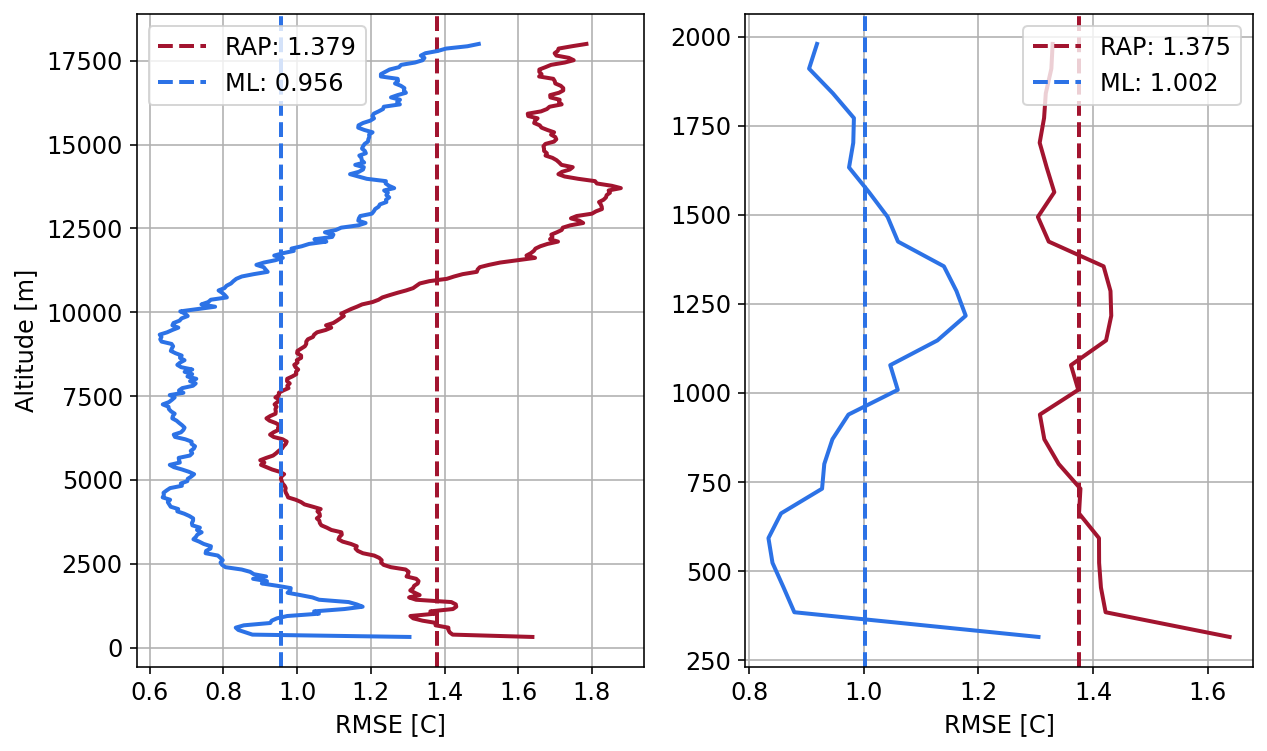

In [204]:
plot_altitude_rmse_verticle(nnet, {'im': IMtrain, 'rap': RAPtrain}, RAOBtrain, RAPtrain[:,:,TEMPERATURE], alt=raob[0, :, -1])  

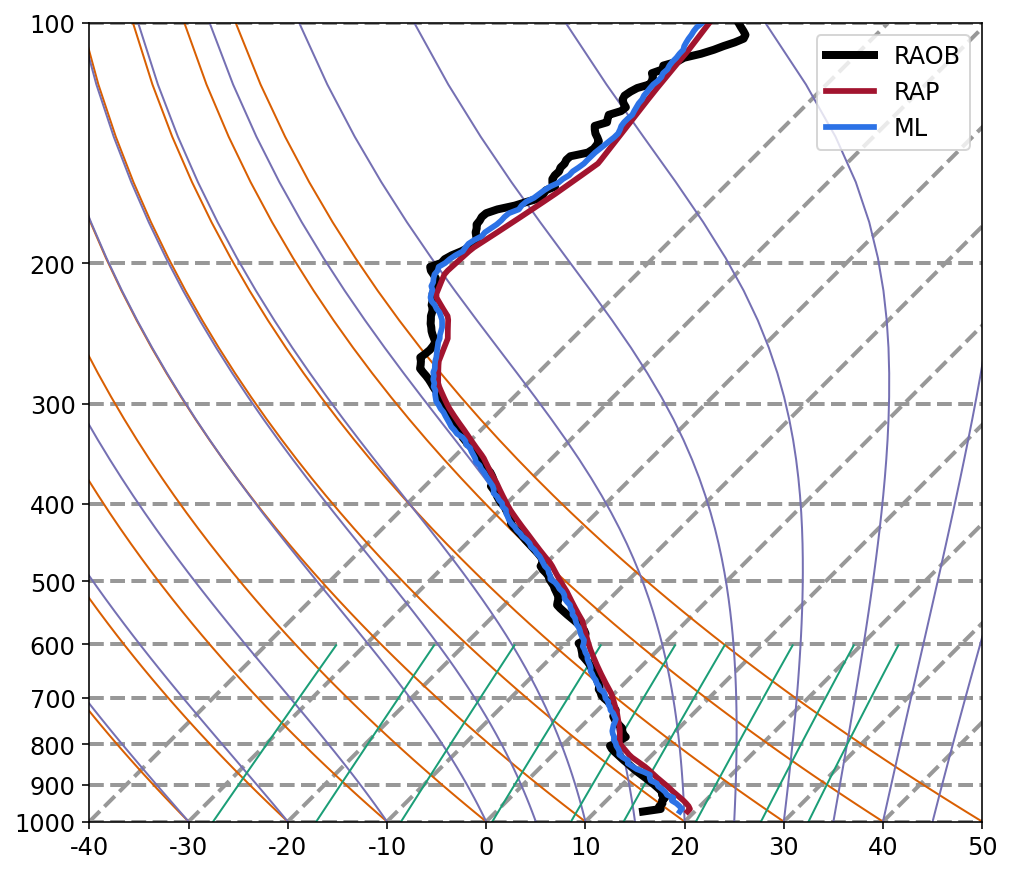

In [205]:
i = 14
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtest[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtest[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtest[i,:,TEMPERATURE]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = nnet.use({'im':IMtest[i:i+1],'rap':RAPtest[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

### Moisture

In [207]:
RAPtrain, RAOBtrain, _, RTMAtrain, RAPtest, RAOBtest, _, RTMAtest = parition(rap=rap, raob=raob, rtma=rtma)

input_dims = [PRESSURE, DEWPOINT]

RAPtrain = RAPtrain[:, :, input_dims]
RAOBtrain = RAOBtrain[:, :, DEWPOINT]

RAPtest = RAPtest[:, :, input_dims]
RAOBtest = RAOBtest[:, :, DEWPOINT]

RAPtrain.shape, RAOBtrain.shape, RTMAtrain.shape, RAPtest.shape, RAOBtest.shape, RTMAtest.shape

((587, 256, 2),
 (587, 256),
 (587, 3, 3, 3),
 (147, 256, 2),
 (147, 256),
 (147, 3, 3, 3))

In [208]:
# https://github.com/tensorflow/tensorflow/issues/36465#issuecomment-631358715

goes_hiddens_list = [[nu] * nl for nu in [8, 16, 32] for nl in range(1, 4)]
n_units_in_conv_layers = [[nu] * nl for nu in [16, 32, 128] for nl in range(1, 4)]

train_percentage = []
test_percentage = []

top = float('inf')
best_nnet = None

product = list(itertools.product(goes_hiddens_list, n_units_in_conv_layers))

f = FloatProgress(min=0, max=len(product))
display(f)

for goes_hiddens, n_units_in_conv in product:
    nnet = nn.MultiNeuralNetwork(RTMAtrain.shape[1:], RAPtrain.shape[1:],
                                    goes_hiddens, n_units_in_conv, [(10, 1)]*len(n_units_in_conv), 
                                    RAOBtrain.shape[1], im_activation='tanh', rap_activation='tanh', seed=1234)
    nnet.train(RTMAtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
               verbose=False, learning_rate=0.001)

    Y = nnet.use({'im': RTMAtrain, 'rap': RAPtrain})
    train_percentage.append(ml.rmse(RAOBtrain, Y))

    Y = nnet.use({'im': RTMAtest, 'rap': RAPtest})
    temp = ml.rmse(RAOBtest, Y)
    test_percentage.append(temp)

    if temp < top:
        best_nnet = nnet
        top = temp
        
    del nnet
    
    f.value += 1

FloatProgress(value=0.0, max=81.0)

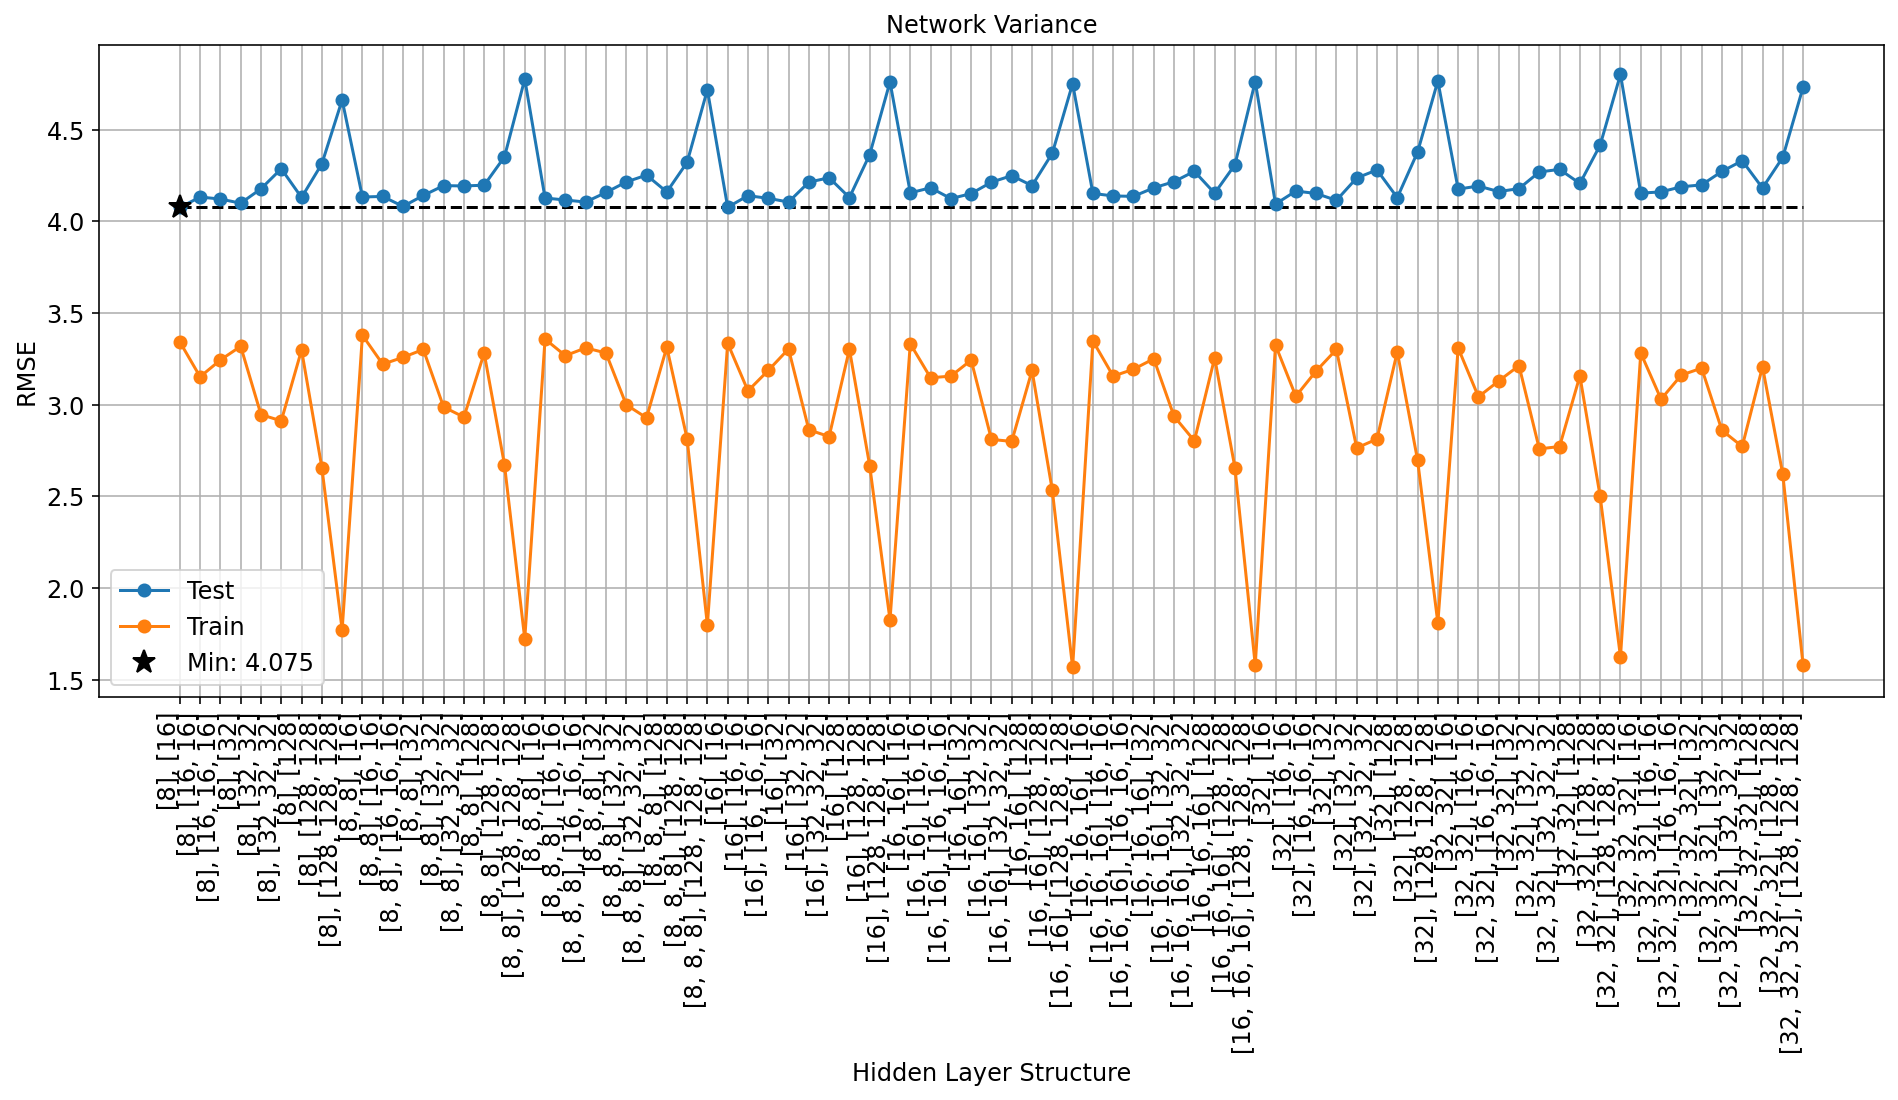

In [209]:
plt.figure(figsize=(16, 6))
plt.plot(test_percentage, 'o-')
plt.plot(train_percentage, 'o-')

top_index = np.argmin(test_percentage)
top = test_percentage[top_index]

plt.hlines(top, 0, len(product) - 1, linestyle='dashed', color='black')
plt.plot(top_index, top, 'k*', markersize=12)
plt.xticks(range(len(product)), [str(p)[1:-1] for p in product],
           rotation=90, horizontalalignment='right')

plt.legend(('Test', 'Train', 'Min: {:.3f}'.format(top)))
plt.grid(True); plt.title('Network Variance')
plt.xlabel('Hidden Layer Structure'); plt.ylabel('RMSE');

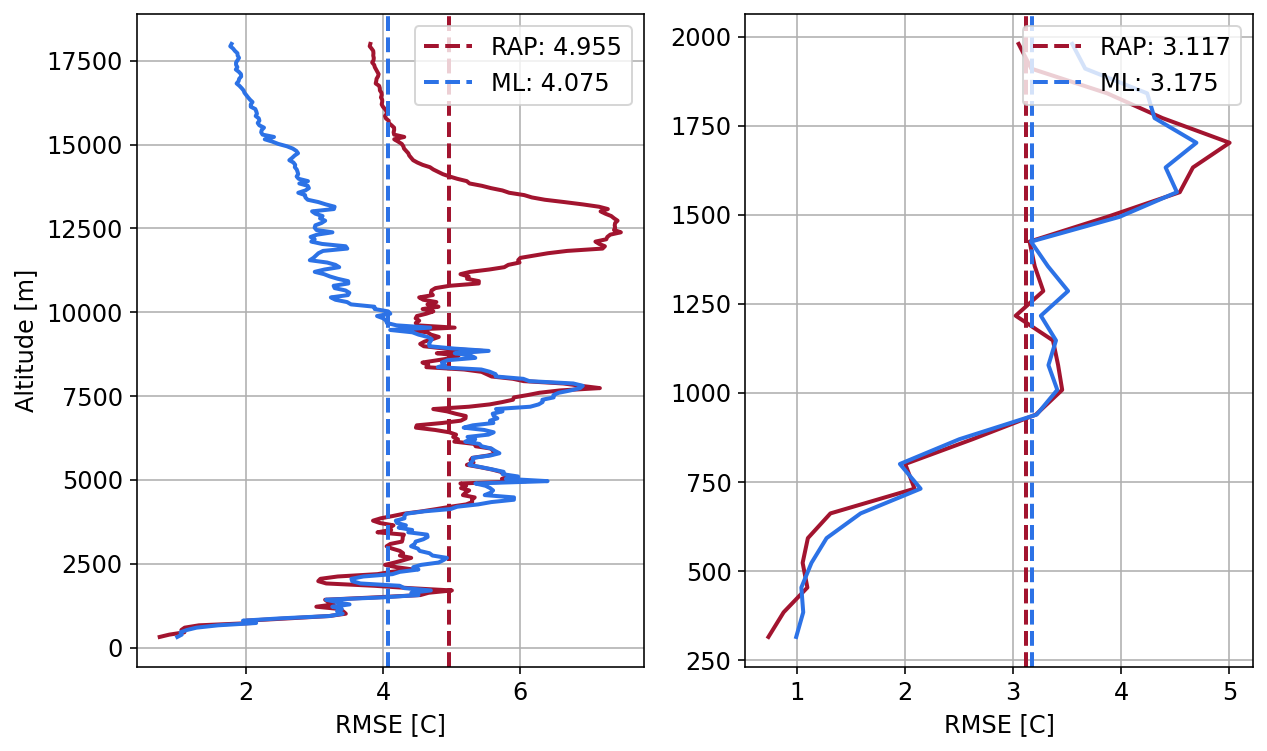

In [210]:
plot_altitude_rmse_verticle(best_nnet, {'im': RTMAtest, 'rap': RAPtest}, RAOBtest, RAPtest[:,:,-1], alt=raob[0, :, -1])
                   #file_name=f"/home/stock/research/media/rap_goes_rmse.png")  

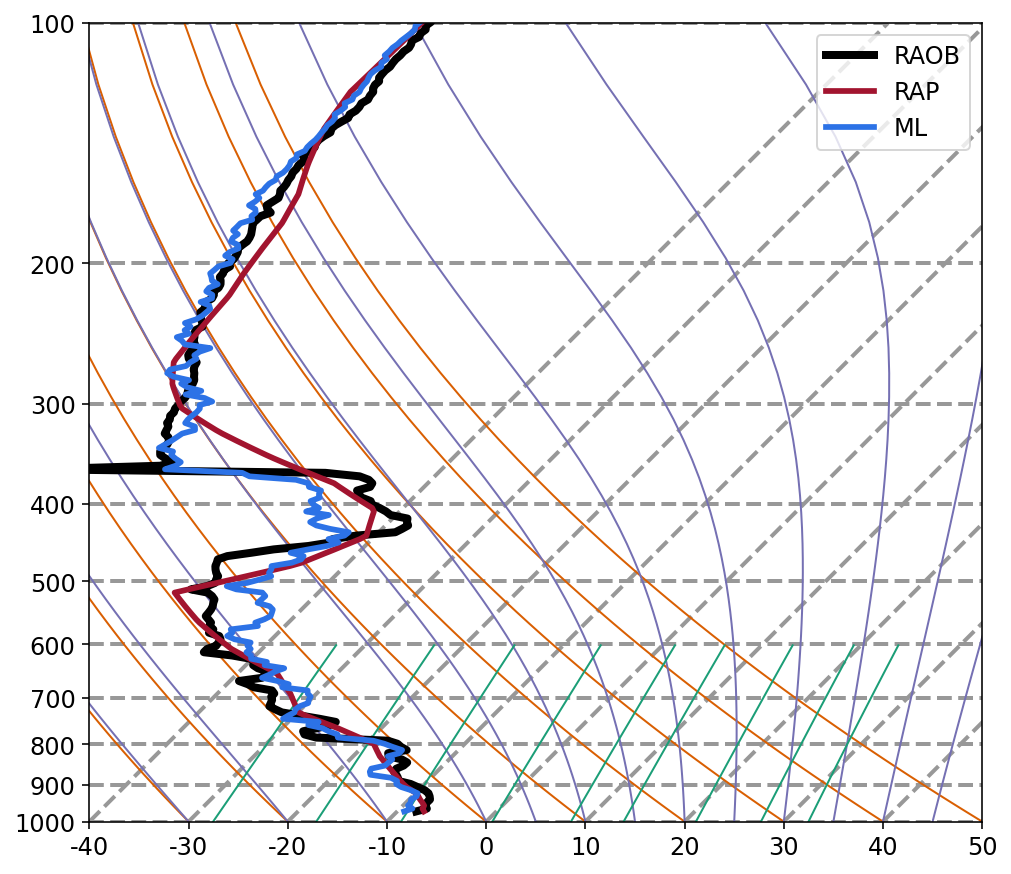

In [213]:
i = 17
sounding = dict()
sounding[radiosonde_utils.PRESSURE_COLUMN_KEY] = RAPtrain[i,:,PRESSURE]
sounding[radiosonde_utils.TEMPERATURE_COLUMN_KEY] = RAOBtrain[i]
sounding[radiosonde_utils.NWP_TEMPERATURE_COLUMN_KEY] = RAPtrain[i,:,-1]
sounding[radiosonde_utils.PREDICTED_TEMPERATURE_COLUMN_KEY] = best_nnet.use({'im':RTMAtrain[i:i+1],'rap':RAPtrain[i:i+1]})[0]

radiosonde_plotting.plot_nwp_ml_sounding(sounding);

In [232]:
interm = tf.keras.Model(best_nnet.model.inputs,best_nnet.model.get_layer('concatenate').output)
def iterm_predict(goes, rap):
    goes = best_nnet._standardizeIM(goes)
    rap  = best_nnet._standardizeRAP(rap)
    return interm.predict({'im': goes, 'rap': rap})

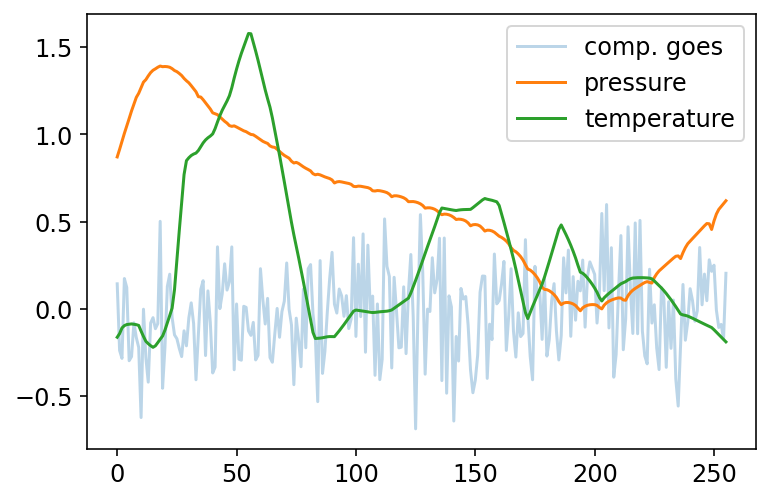

In [233]:
i = 2
Y = iterm_predict(RTMAtrain[i:i+1], RAPtrain[i:i+1])

plt.plot(Y[0,:,2], alpha=0.3, label='comp. goes')
plt.plot(Y[0,:,0], label='pressure')
plt.plot(Y[0,:,1], label='temperature')

plt.legend();

In [216]:
rtma_type_indicies = np.arange(len(rtma_type))
combinations = []
for length in rtma_type_indicies:
    combinations += list(itertools.combinations(rtma_type_indicies, length+1))

In [219]:
all_trials = []

for c in combinations:

    IMtrain = RTMAtrain[:,:,:, c]
    IMtest = RTMAtest[:,:,:, c]

    trial = []

    for t in range(10):
        nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                                    [8], [16], [(10, 1)], 
                                    RAOBtrain.shape[1], im_activation='tanh',
                                    rap_activation='tanh')

        nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
                   verbose=False, learning_rate=0.001)

        Y = nnet.use({'im': IMtest, 'rap': RAPtest})
        rmse = ml.rmse(Y, RAOBtest)

        trial.append(rmse)
        
    all_trials.append(trial)
    
all_trials = np.asarray(all_trials)

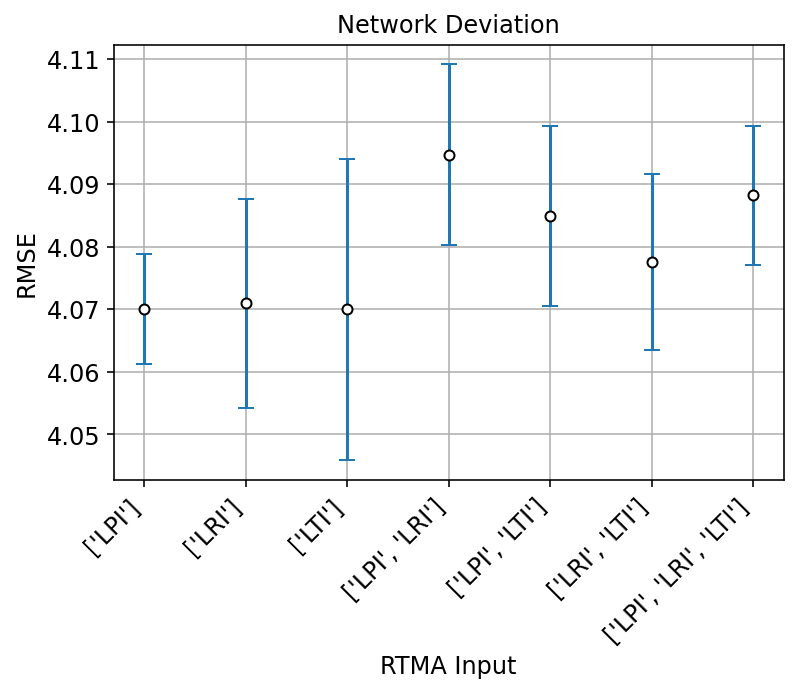

In [220]:
labels = [rtma_type[list(c)].tolist() for c in combinations]

fig, ax = plt.subplots(1, figsize=(6, 4))

ax.errorbar(np.arange(len(combinations)), all_trials.mean(axis=1), yerr=all_trials.std(axis=1),
             linestyle='None', marker='o', capsize=4, markersize=5,
             markeredgecolor='k', markerfacecolor='w')

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, horizontalalignment='right')

ax.grid(True); ax.set_title('Network Deviation')
ax.set_xlabel('RTMA Input'); ax.set_ylabel('RMSE');

In [221]:
rtma_type

array(['LPI', 'LRI', 'LTI'], dtype='<U3')

In [222]:
IMtrain = RTMAtrain[:,:,:, (0,)]
IMtest = RTMAtest[:,:,:, (0,)]

nnet = nn.MultiNeuralNetwork(IMtrain.shape[1:], RAPtrain.shape[1:],
                             [16], [16], [(10, 1)], 
                             RAOBtrain.shape[1], im_activation='tanh',
                             rap_activation='tanh')

nnet.train(IMtrain, RAPtrain, RAOBtrain, 50, 32, method='adam',
           verbose=False, learning_rate=0.001)

MultiNeuralNetwork(256)
  Final objective value is 0.27589 in 2.4585 seconds.

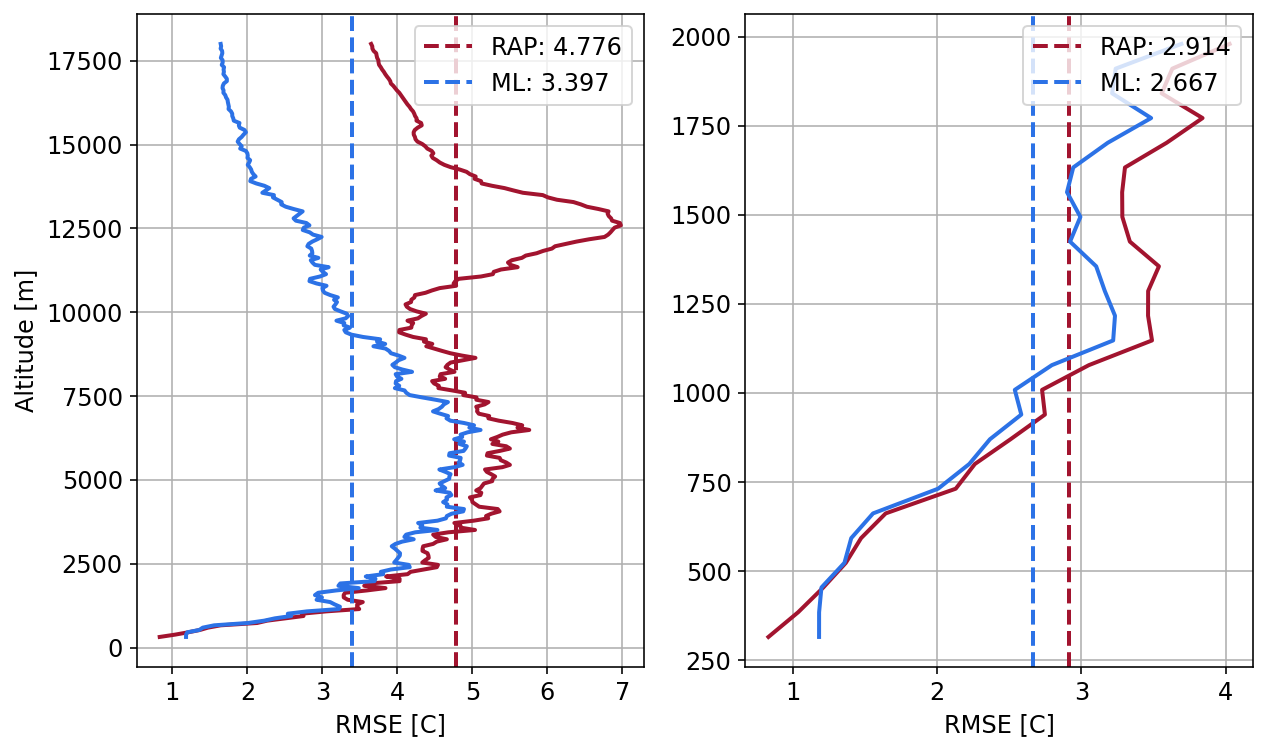

In [223]:
plot_altitude_rmse_verticle(nnet, {'im': IMtrain, 'rap': RAPtrain}, RAOBtrain, RAPtrain[:,:,TEMPERATURE], alt=raob[0, :, -1])  